In [2]:
import os
import warnings
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=UserWarning)

In [10]:
def return_keras_dataloaders():
    train_path = "./chest_xray/train"
    valid_path = "./chest_xray/val"

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    valid_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=64,
        class_mode='binary'
    )

    valid_generator = valid_datagen.flow_from_directory(
        valid_path,
        target_size=(224, 224),
        batch_size=64,
        class_mode='binary'
    )

    return train_generator, valid_generator

In [4]:
def create_xception_model(num_classes):
    base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

In [5]:
# Evaluation Module
def evaluate_model(model, generator):
    y_true = generator.classes
    y_pred = model.predict(generator)

    # Binary Cross-Entropy Loss
    loss = model.evaluate(generator)[0]
    print(f"Binary Cross-Entropy Loss: {loss}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred > 0.5)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred > 0.5))

In [6]:
def create_baseline_model(input_shape):
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

In [7]:
def train_final_model(train_generator, valid_generator, num_classes):
    final_model = create_xception_model(num_classes)
    
    final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = final_model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=5,
        validation_data=valid_generator,
        validation_steps=len(valid_generator)
    )

    return final_model, history

In [8]:
# Plotting
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Training & Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Training & Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [12]:
train_generator, valid_generator = return_keras_dataloaders()

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [13]:
baseline_model = create_baseline_model(input_shape=(224, 224, 3))


83683744/83683744 [==============================] - 37s 0us/step

Epoch 1/5


82/82 [==============================] - 682s 8s/step - loss: 0.3361 - accuracy: 0.8510 - val_loss: 0.3906 - val_accuracy: 0.9375
Epoch 2/5
82/82 [==============================] - 655s 8s/step - loss: 0.2163 - accuracy: 0.9178 - val_loss: 0.3329 - val_accuracy: 0.8125
Epoch 3/5
82/82 [==============================] - 549s 7s/step - loss: 0.1877 - accuracy: 0.9327 - val_loss: 0.3317 - val_accuracy: 0.8125
Epoch 4/5
82/82 [==============================] - 610s 7s/step - loss: 0.1666 - accuracy: 0.9433 - val_loss: 0.3338 - val_accuracy: 0.8750
Epoch 5/5
1/1 [==============================] - 2s 2s/step - loss: 0.3046 - accuracy: 0.8125
Binary Cross-Entropy Loss: 0.3046145737171173


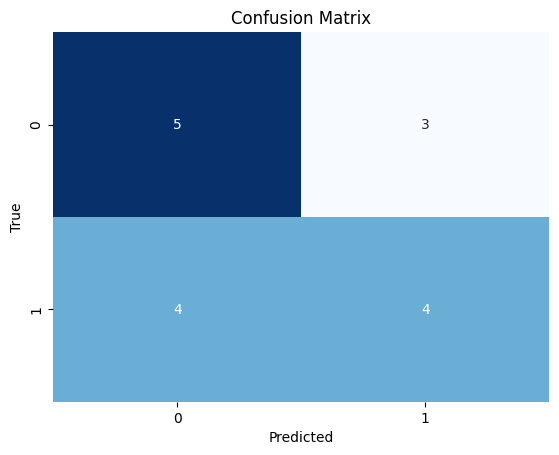

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.57      0.50      0.53         8

    accuracy                           0.56        16
   macro avg       0.56      0.56      0.56        16
weighted avg       0.56      0.56      0.56        16



In [14]:
num_classes = 2 
final_model, history = train_final_model(train_generator, valid_generator, num_classes)
evaluate_model(final_model, valid_generator)

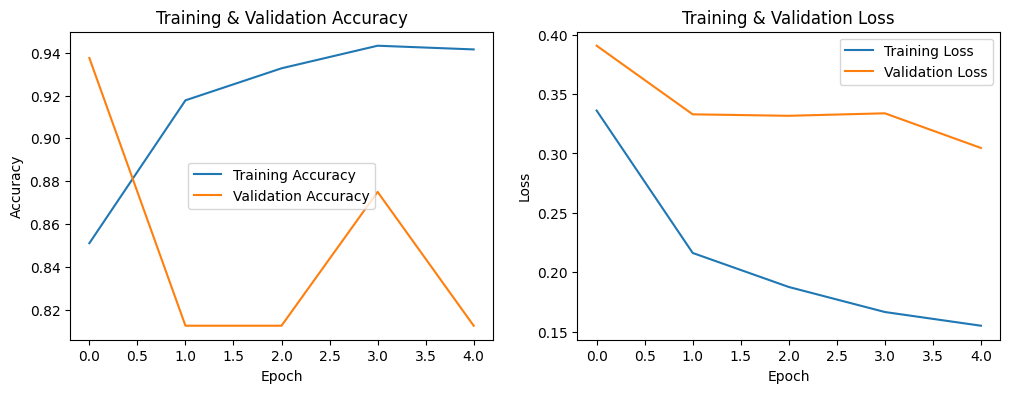

In [15]:
plot_training_history(history)
